# Проект для Викишоп

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Заказчик** — Интернет-магазин «Викишоп».

**Входные данные**  — ```/toxic_comments.csv```

**Результаты исследования** — Получена модель подходящая под требования заказчика (F1 >= 0.75)

## Подготовка

### Импорт используемых библиотек

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re

import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')

from wordcloud import WordCloud

from tqdm.notebook import tqdm

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

# Подавление предупреждений
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Чтение файла

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

In [3]:
np.random.seed(42)

In [4]:
display(df.sample(10))
df.info()

,text,toxic
31055,"Sometime back, I just happened to log on to ww...",0
102929,"""\n\nThe latest edit is much better, don't mak...",0
67385,""" October 2007 (UTC)\n\nI would think you'd be...",0
81167,Thanks for the tip on the currency translation...,0
90182,I would argue that if content on the Con in co...,0
1860,"""=Reliable sources===\nCheating:\n""""Barry Bond...",1
125422,WTF=\n\nHow The Fuck Does This Person Merit A ...,1
149142,"cajuns, acadians\nCajuns, acadians, louisianan...",0
89784,Hi - I dropped a pin in Google Maps at the cer...,0
64323,Re removal of accessdate= for urls books \n\nT...,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


- Датасет имеет 3 столбца и 159292 тыс. строк
- Имеется столбец unnamed, который дублирует индекс. Он никакой информации не несет
- Пропуски отсутствуют

Глянем на баланс целевого признака

In [5]:
df['toxic'].value_counts(normalize=True)*100

0    89.838787
1    10.161213
Name: toxic, dtype: float64

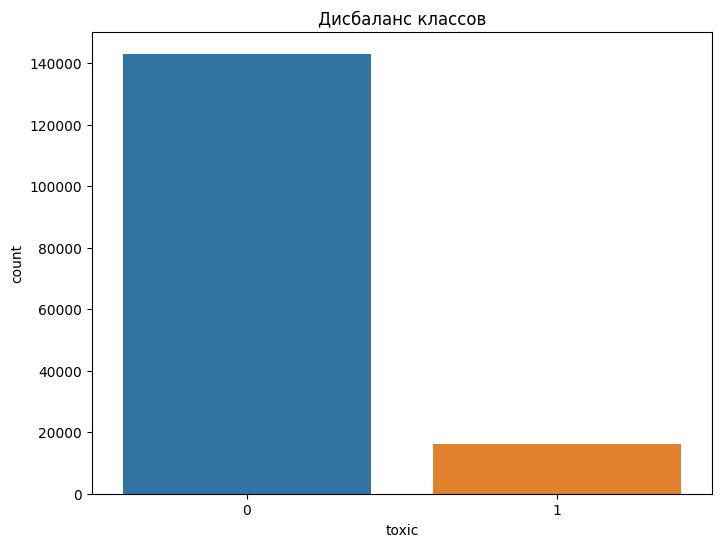

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Дисбаланс классов')
plt.xlabel('Class')
plt.ylabel('Count')
sns.countplot(x='toxic', data=df);

Очевиден дисбаланс: соотношение `0` к `1` - 9:1

### Лемматизация

Воспользуемся пакетом Spacy Lemmatizer

In [7]:
%%time
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def text_preprocessing(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())

CPU times: total: 438 ms
Wall time: 413 ms


In [8]:
%%time
tqdm.pandas() 
df['lemm_text'] = df['text'].progress_apply(text_preprocessing).str.lower()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 13min 14s
Wall time: 13min 14s


In [9]:
df.sample(10)

,text,toxic,lemm_text
17234,"Murrumbidgee means 'track goes down here', 'a ...",0,murrumbidgee mean track go down here a very go...
65584,You just changed the article after discussion ...,0,you just change the article after discussion d...
125277,There! I got a little (very little) info on ba...,0,there i get a little very little info on basic...
75724,"""\n\n Blocked \n\nI have temporarily blocked y...",0,block i have temporarily block your account fo...
14311,Thanks for experimenting with the page Bonzi B...,0,thank for experiment with the page bonzi buddy...
33077,"""\n Page Macedonia recent edit wars \nEven if ...",0,page macedonia recent edit war even if general...
125041,I just think a word or two on the similarities...,0,i just think a word or two on the similarity s...
74973,:User:Elizabethcmurphy\nA tag has been placed ...,0,user elizabethcmurphy a tag have be place on u...
149994,Inspirations \n\nShould Solaris by Stanislaw L...,0,inspiration should solaris by stanislaw lem be...
148472,Bill2Phone deletion \n\nI am unsure why you th...,0,bill phone deletion i be unsure why you think ...


Построим облако слов, чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах.

In [10]:
toxic_text = df[df['toxic'] == 1]['lemm_text']
non_toxic_text = df[df['toxic'] == 0]['lemm_text']

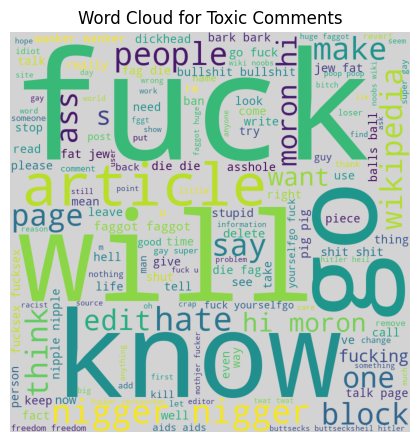

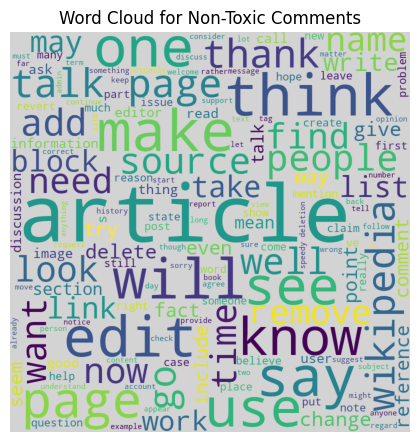

In [11]:
# Создание облака слов для токсичных комментариев
toxic_wordcloud = WordCloud(width=800, height=800,
                            background_color='lightgrey',
                            max_words=150).generate(" ".join(toxic_text))

plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(toxic_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word Cloud for Toxic Comments")
plt.show()

# Создание облака слов для нетоксичных комментариев
non_toxic_wordcloud = WordCloud(width=800, height=800,
                                background_color='lightgrey',
                                max_words=150).generate(" ".join(non_toxic_text))

plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(non_toxic_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word Cloud for Non-Toxic Comments")
plt.show()

### Добавление признака

Добавим новый признак - тональность (настроение) текста. Используем для этого `SentimentIntensityAnalyzer`

In [12]:
# Создание экземпляра SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Применение анализатора настроения к тексту и создание новой колонки с оценкой настроения
df['sentiment_score'] = df['lemm_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [13]:
df.head()

,text,toxic,lemm_text,sentiment_score
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...,0.5574
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i be see...,0.3612
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i be really not try to edit war it be ...,-0.1779
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can not make any real suggestion on imp...,0.2263
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...,0.6808


### Деление на выборки

Выделим признаки

In [14]:
features = df.drop(['toxic', 'text'], axis=1)
target = df['toxic']

Разделим на выборки

In [15]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.2,
    stratify=target)

## Обучение

Создадим список, в который будут вноситься модели с лучшей метрикой `f1`

In [23]:
model_list = pd.DataFrame(columns=['model', 'f1'])

Зададим список стоп-слов, которые конвертируется в набор для более эффективной проверки наличия слов в тексте.

In [24]:
stopwords = set(stopwords.words('english'))

Преобразуем текст в вектор

In [25]:
preprocessor = ColumnTransformer(
                    [("tfidf", TfidfVectorizer(stop_words=stopwords), "lemm_text")]
)

### LogisticRegression

In [26]:
%%time

pipeline_lr = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("lr", LogisticRegression())
    ]
)

parameters = {
    "lr__C":[0.01, 0.1, 1.0, 10.0], 
    "lr__penalty":["l1","l2"],
    "lr__class_weight": ['balanced']
}

grid_lr = GridSearchCV(pipeline_lr, parameters, scoring="f1", cv=2)
grid_lr.fit(features_train, target_train)

print('F1-мера модели LogisticRegression', grid_lr.best_score_)
print('Лучшие гиперпараметры', grid_lr.best_params_)

F1-мера модели LogisticRegression 0.7633160827864115
Лучшие гиперпараметры {'lr__C': 10.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}
CPU times: total: 2min 8s
Wall time: 1min 19s


In [27]:
model_list = model_list.append({'model': 'LogisticRegression',
                                'f1': grid_lr.best_score_}, ignore_index=True)

### LinearSVC

In [30]:
%%time

pipeline_svc = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("svc", LinearSVC())
    ]
)

parameters = {
    "svc__C":[0.01, 0.1, 1.0, 10.0], 
    "svc__class_weight": ['balanced']
}

grid_svc = GridSearchCV(pipeline_svc, parameters, scoring="f1", cv=3)
grid_svc.fit(features_train, target_train)

print('F1-мера модели LinearSVC', grid_svc.best_score_)
print('Лучшие гиперпараметры', grid_svc.best_params_)

F1-мера модели LinearSVC 0.7610910553483942
Лучшие гиперпараметры {'svc__C': 1.0, 'svc__class_weight': 'balanced'}
CPU times: total: 1min 31s
Wall time: 1min 32s


In [31]:
model_list = model_list.append({'model': 'LinearSVC',
                                'f1': grid_svc.best_score_}, ignore_index=True)

### DecisionTreeClassifier

In [32]:
%%time

pipeline_dt = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("dt", DecisionTreeClassifier())
    ]
)

parameters = {
    "dt__max_depth":[None, 3], 
    "dt__min_samples_split": [2],
    "dt__min_samples_leaf": [2]
}

grid_dt = GridSearchCV(pipeline_dt, parameters, scoring="f1", cv=2)
grid_dt.fit(features_train, target_train)

print('F1-мера модели DecisionTreeClassifier', grid_dt.best_score_)
print('Лучшие гиперпараметры', grid_dt.best_params_)

F1-мера модели DecisionTreeClassifier 0.7005382909478262
Лучшие гиперпараметры {'dt__max_depth': None, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2}
CPU times: total: 9min 19s
Wall time: 9min 21s


In [33]:
model_list = model_list.append({'model': 'DecisionTreeClassifier',
                                'f1': grid_dt.best_score_}, ignore_index=True)

### RandomForestClassifier

In [34]:
%%time

pipeline_rf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rf", RandomForestClassifier())
    ]
)

parameters = {
    "rf__max_depth":[None, 3], 
    "rf__min_samples_split": [2],
    "rf__min_samples_leaf": [2],
    "rf__n_estimators": [100]
}

grid_rf = GridSearchCV(pipeline_rf, parameters, scoring="f1", cv=2)
grid_rf.fit(features_train, target_train)

print('F1-мера модели RandomForestClassifier', grid_rf.best_score_)
print('Лучшие гиперпараметры', grid_rf.best_params_)

F1-мера модели RandomForestClassifier 0.6300860054924793
Лучшие гиперпараметры {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
CPU times: total: 5min 41s
Wall time: 5min 41s


In [35]:
model_list = model_list.append({'model': 'RandomForestClassifier',
                                'f1': grid_rf.best_score_}, ignore_index=True)

### Вывод

In [36]:
model_list

,model,f1
0,LogisticRegression,0.763316
1,LinearSVC,0.761091
2,DecisionTreeClassifier,0.700538
3,RandomForestClassifier,0.630086


Лучшую `F1`-меру показала модель `LogisticRegression` - **0.76**. Ее и будем тестировать

## Тестирование

In [37]:
lr_model = grid_lr.best_estimator_

In [38]:
f1_score(target_test, lr_model.predict(features_test))

0.7579279667097146

Модель показала удовлитворительные результаты: f1 > 0.75
___
Можно улучшить метрику, определив оптимальный порог для классификации

In [39]:
yhat = lr_model.predict_proba(features_test)

In [40]:
probs = yhat[:, 1]
thresholds = np.arange(0, 1, 0.001)

In [41]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [42]:
scores = [f1_score(target_test, to_labels(probs, t)) for t in thresholds]

In [43]:
ix = np.argmax(scores)
print('Threshold = %.3f, F1 = %.5f' % (thresholds[ix], scores[ix]))

Threshold = 0.764, F1 = 0.78228


Сумели поднять метрику F1 до 0.78738

Посмотрим, какие слова является наиболее важным для классификации с точки зрения модели.

In [44]:
words = grid_lr.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

In [45]:
weights = grid_lr.best_estimator_.named_steps['lr'].coef_[0]

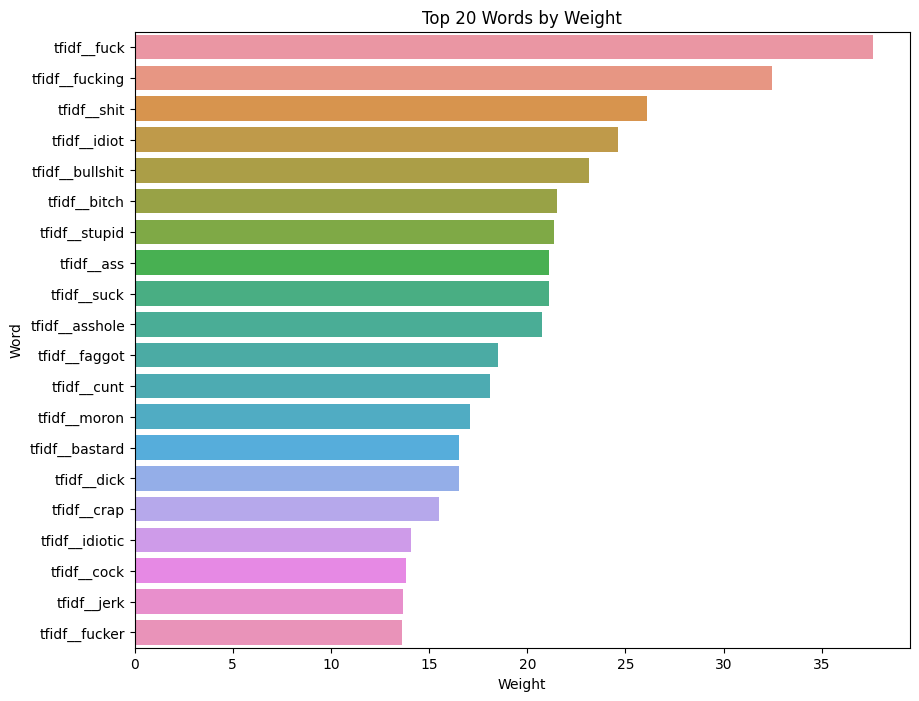

In [46]:
# Создайте DataFrame из слов и весов
weights_df = pd.DataFrame({'word': words, 'weight': weights})

# Отсортируйте DataFrame по весам
weights_df = weights_df.sort_values(by='weight', ascending=False)

# Создайте график Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='weight', y='word', data=weights_df.head(20))  # Выведите первые 20 слов с наибольшими весами
plt.xlabel('Weight')
plt.ylabel('Word')
plt.title('Top 20 Words by Weight')
plt.show()

Слова, которые чаще всего влияют на классификацию токсичности комментария:
- `fuck`
- `fucking`
- `shit`
- `idiot`

## Общий вывод:

Целью исследования являлся поиск инструмента, который будет искать токсичные комментарии и отправлять их на модерацию. В распоряжении был набор данных с разметкой о токсичности правок.
___
Датасет содержал в себе 2 столбца (столбец `text` содержит текст комментария, а `toxic` — целевой признак) и 159292 тыс. строк и имел дисбаланс классов целевого признака (`toxic`): доли значений **0** и **1** - 90% и 10% соответственно.
___
Почистили текст от лишних символов, привели к единому регистру (нижнему), провели лемматизацию, использовав пакет `Spacy Lemmatizer`. Получили признак `lemm_text`.
___
Добавили новый признак (`sentiment_score`) - тональность/настроение текста, использовав `SentimentIntensityAnalyzer`.
___
Выделили целевой признак (`toxic`) и фичи (`lemm_text`,`sentiment_score`). Разбили данные на выборки в соотношении 9 к 1 со стратификацией, чтобы сохранить соотношение классов в обеих выборках.
___
Было выбрано 4 модели для обучения: `LogisticRegression`,`LinearSVC`,`DecisionTreeClassifier`,`RandomForestClassifier`. В поисках лучших гиперпараметров использовал функции `GridSearchCV` + `pipeline`.
___
Метрика F1 каждой модели с лучшими подобранными гиперпараметрами:
- `LogisticRegression` - **0.763316**
- `LinearSVC` - 0.761091
- `DecisionTreeClassifier` - 0.700538
- `RandomForestClassifier` - 0.630086

Модель логистической регрессии показала наилучший результат
___
Узнали, какие слова является наиболее важным для классификации с точки зрения модели:
- `fuck`
- `fucking`
- `shit`
- `idiot`
___

F1-мера `LogisticRegression` на тестовой выборке - **0.758**, что удовлетворяет заданным условиям (F1 модели должна быть больше 0.75).
Предприняли меру, для улучшения метрики, определив оптимальный порог для классификации: 
- Threshold = 0.764
- f1 = 0.78228

Определение оптимального порога помогло увеличить метрику `f1` до **0.782**